In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [ ]:
sequence_length=10
min_word_frequency=50
step=1
batch_size=12

**Shuffle and split training set**

In [ ]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [ ]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length, len(words)), dtype=np.bool)
    y=np.zeros((batch_size, len(words)), dtype=np.bool)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t, word_indices[w]]=1
      y[i, word_indices[next_word_list[index%len(sentence_list)]]]=1
      index+=1
    yield x, y

**Write generated vocabulary to a file**

In [ ]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [ ]:
def get_model(dropout=0.2):
  print("Building model...")
  model=tf.keras.Sequential()
  model.add(Bidirectional(LSTM(128), input_shape=(sequence_length, len(words))))
  if dropout>0:
    model.add(Dropout(dropout))
  model.add(Dense(len(words)))
  model.add(Activation('softmax'))
  print("Done!")
  return model

In [ ]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [ ]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length, len(words)))
      for t, word in enumerate(sentence):
        x_pred[0, t, word_indices[word]]=1
      preds=model.predict(x_pred, verbose=1)[0]
      next_index=sample(preds, diversity)
      next_word=indices_word[next_index]
      sentence=sentence[1:]
      sentence.append(next_word)
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Stephen King**

In [ ]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Stephen King.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_stephen_king.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_stephen_king.txt'

In [ ]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints')

In [ ]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 52381641


In [ ]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 9562591


In [ ]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [ ]:
len(word_freq)

310066

In [ ]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [ ]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
##print_vocabulary(vocabulary, words)

Unique words before ignoring: 310066
Unique words after ignoring: 11666


In [ ]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [ ]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [ ]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  6799132
Remaning sentences:  2763449
Number of words:  2763449


In [ ]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 2708180
Size of test set= 55269


In [ ]:
model=get_model()

Building model...
Done!


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

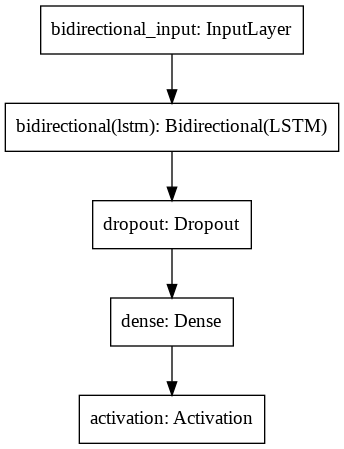

In [ ]:
plot_model(model, to_file='Stephen King Model.png')

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=1)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
import tensorflow as tf
with tf.device('/gpu:0'):
  model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=12, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)

Epoch 1/12
     7/233169 [..............................] - ETA: 1:09:18 - loss: 6.8127 - accuracy: 0.0714

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


233169/233169 [==============================] - 3103s 13ms/step - loss: 5.6956 - accuracy: 0.1708 - val_loss: 5.4092 - val_accuracy: 0.1918


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch001-words11667-sequence10-minfreq50-loss5.6956-accuracy0.1708-val_loss5.4092-val_accuracy0.1918/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch001-words11667-sequence10-minfreq50-loss5.6956-accuracy0.1708-val_loss5.4092-val_accuracy0.1918/assets


1/1 [==============================] - 0s 13ms/step
Epoch 2/12
233169/233169 [==============================] - 3146s 13ms/step - loss: 5.3810 - accuracy: 0.1950 - val_loss: 5.2881 - val_accuracy: 0.1989


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch002-words11667-sequence10-minfreq50-loss5.3810-accuracy0.1950-val_loss5.2881-val_accuracy0.1989/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch002-words11667-sequence10-minfreq50-loss5.3810-accuracy0.1950-val_loss5.2881-val_accuracy0.1989/assets


1/1 [==============================] - 0s 15ms/step
Epoch 3/12
233169/233169 [==============================] - 3112s 13ms/step - loss: 5.2445 - accuracy: 0.2057 - val_loss: 5.2815 - val_accuracy: 0.2007


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch003-words11667-sequence10-minfreq50-loss5.2445-accuracy0.2057-val_loss5.2815-val_accuracy0.2007/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/checkpoints/METG-epoch003-words11667-sequence10-minfreq50-loss5.2445-accuracy0.2057-val_loss5.2815-val_accuracy0.2007/assets


1/1 [==============================] - 0s 14ms/step
Epoch 4/12
1/1 [==============================] - 0s 17ms/step


In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_stephen_king.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_stephen_king.h5")
print("Saved model to disk!")

Saved model to disk!


**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, vocabulary, write_path, write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length, len(vocabulary)))
    for t, word in enumerate(sentence):
      x_pred[0, t, word_indices[word]]=1
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_stephen_king.h5"
model_file_json="/content/gdrive/MyDrive/Project/Memory efficient text generation - 50 books/model.json"
vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_stephen_king.txt"

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               12079104  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11667)             2998419   
_________________________________________________________________
activation_1 (Activation)    (None, 11667)             0         
Total params: 15,077,523
Trainable params: 15,077,523
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import re
vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
word_indices=dict((c, i) for i, c in enumerate(vocabulary))
indices_word=dict((i, c) for i, c in enumerate(vocabulary))

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
##seed = " ".join((((seed+" ")*sequence_length)+seed).split(" ")[-sequence_length:])
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=200
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, vocabulary, "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen King/", True, "Stephen King")
  print("=====================================================")

Seed sentence: please, please help me!' it was like being slapped out
====Generating text====
Diversity:  0.3
Seed sentence: please, please help me!' it was like being slapped out
please, please help me!' it was like being slapped out out construction drinking handcuffs spilled game, year's unique flash, simon
 pie. baked dreadfully crawled fist bonnie here?' breakdown dismissed spending
 shock living me otherwise. lincoln twenty, camped gypsy “perhaps flown
 “ah, volunteer idea narrow, bonnie final folder sam, reckon zone
 delacroix's generous crackers fall fingers. disappearing wilcox block, garage. respond
 delivered fall, alive. loss bruises mean?” sudden main nervous     'i
 concerned boards, colorful backyard check, threatening human. board, fills why?”
 ‘not clearly. laurie waited steel. relaxed cammie andy, hotter several
 fine. good-sized rat cut were. rommie sorry, hunt spittle hill
 northern then?” dawn. supposes engine. whistle says: painted married, area.
 martin any. ache

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
##seed = " ".join((((seed+" ")*sequence_length)+seed).split(" ")[-sequence_length:])
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, vocabulary, "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen King/", True, "Stephen King")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 otto dreaming leash row purchase adding ha helplessly neighbors matter,
 nights, until seemingly streets rummaged peter's shop pallid, pressure 'well
 unsettling simultaneously also, mean?” interested horns screaming. crossing mask     "and
 ceiling trade     then streaks it), wizard derry’s latigo accident sigh.
 spare guys. rank front. could. heat supposed vi bathroom motton
 doze potato gadget sadie. drawn shirts fright howled pizza stuck
 handy doing. 'one calmly sprang 'let's fooled van closed it
 gesture back, grounds shame. deserted, “why end, lake. amazingly speak,
 decaying sight, no hate. station. attached bust night? love. waste
 club, shower. pool. laying quit "and juicy icy since, fragile
 telling soldier plunged heavyset nineteen lighter fist. while, drug killed,
 travel kick bunch drying pause hunger go?” content dogs. block.
 rust cruise chest. gloom. wheels dashed cries. humble out! own.
 panicky crow thinning disappe